In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Create fake customer data
np.random.seed(42)
customer_ids = [f"C{str(i).zfill(4)}" for i in range(1, 101)]
today = datetime.today()

data = []

for customer in customer_ids:
    num_orders = np.random.randint(1, 10)
    for _ in range(num_orders):
        days_ago = np.random.randint(1, 365)
        date = today - timedelta(days=days_ago)
        amount = round(np.random.uniform(10.0, 500.0), 2)
        data.append([customer, date, amount])

df = pd.DataFrame(data, columns=['CustomerID', 'InvoiceDate', 'Amount'])

# Show sample
df.head()


,CustomerID,InvoiceDate,Amount
0,C0001,2024-04-21 14:45:56.964004,99.88
1,C0001,2025-01-23 14:45:56.964004,303.34
2,C0001,2024-12-23 14:45:56.964004,228.46
3,C0001,2024-09-02 14:45:56.964004,38.46
4,C0001,2025-01-07 14:45:56.964004,173.52


In [3]:
# Set a reference date for recency (usually the latest date + 1)
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

# Group by customer and calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'CustomerID': 'count',                                     # Frequency
    'Amount': 'sum'                                            # Monetary
})

# Rename the columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'CustomerID': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

# Show the RFM table
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
C0001,72,7,1238.26
C0002,51,8,1258.64
C0003,89,4,1107.10
C0004,265,2,145.92
C0005,2,7,1315.05


In [4]:
# RFM Scoring: divide each metric into 1–4 quartiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine them into a single RFM score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# Show updated table
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
C0001,72,7,1238.26,2,3,3,233,8
C0002,51,8,1258.64,2,4,3,243,9
C0003,89,4,1107.10,2,2,2,222,6
C0004,265,2,145.92,1,1,1,111,3
C0005,2,7,1315.05,4,3,3,433,10


In [5]:
# Segment customers by RFM Score
def segment_customer(score):
    if score >= 9:
        return 'Top Customers'
    elif score >= 6:
        return 'Loyal Customers'
    elif score >= 4:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# See how many customers fall into each segment
rfm['Segment'].value_counts()


,count
Segment,
Top Customers,41
Loyal Customers,28
Potential,21
At Risk,10


<ipython-input-6-a13a4a9176a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


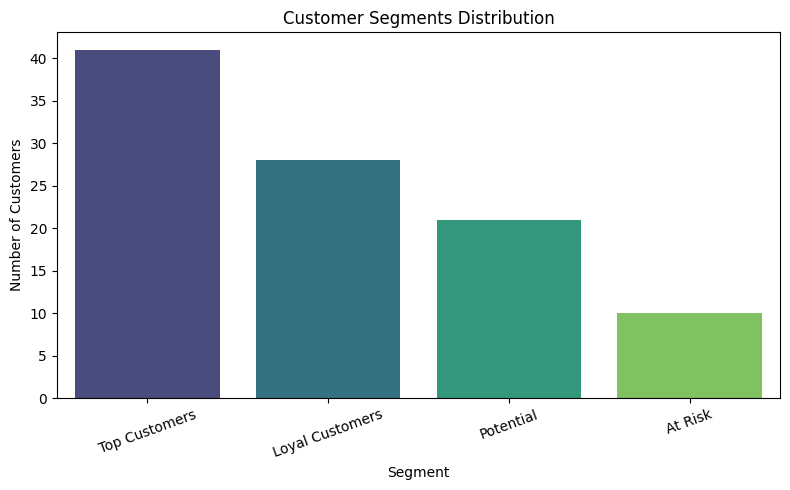

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
